# SiPM Showers

#### 1) Select events using a run's DST file -- > 2) Look at those events' waveforms

Here, I use this notebook to look at the waveforms of sodium events near the photoelectric peak

In [1]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-27 22:53:36


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import time
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from invisible_cities.database import load_db
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.params import S12Params, ThresholdParams
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.core.core_functions import in_range
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.reco.pmaps_functions import plot_s12

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from icaro.core.event_pmaps     import EventPmaps, print_s12, print_s2si
from icaro.core.kdst_functions  import load_dst, event_rate, profile_and_fit, print_fit, chi2
from icaro.core.hst_functions   import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                                     doublescatter, covariance, reso, gausstext, plot_profile_histogram 

### Run Parameters

In [4]:
run_number =  3769

# consecutive! could do a little more work and make them not have to be consecutive
subruns     = ['100', '101', '102', '103', '104', '105']

In [5]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

Define External SiPMs

In [6]:
nsipm = 1792
ext_t = 170 * units.mm
ext_sipms = np.where(np.sqrt(xs **2 + ys ** 2) > ext_t)[0]
mask            = np.ones_like(xs, dtype=bool)
mask[ext_sipms] = False
int_sipms = np.where(mask)[0]
assert       len(int_sipms) + len(ext_sipms)  == 1792
assert  list(set(int_sipms) | set(ext_sipms)) == list(range(nsipm))
print(len(int_sipms), len(ext_sipms))

912 880


### 1) HAVE ACCESS TO WVFMS FROM CONSECTIVE SUBRUNS

In [7]:
## consecutive meaning subrun 025, 026, 027... for ex

RWF_path = os.path.join(os.environ['IC_DATA'], 'LSC/wvfms/{}/'.format(run_number))
RWF_files = [RWF_path + 'dst_waves.gdcsnext.{}_{}.root.h5'.format(subrun, run_number) for subrun in subruns]
print(RWF_files)

['/Users/alej/Desktop/IC_DATA/LSC/wvfms/3769/dst_waves.gdcsnext.100_3769.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3769/dst_waves.gdcsnext.101_3769.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3769/dst_waves.gdcsnext.102_3769.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3769/dst_waves.gdcsnext.103_3769.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3769/dst_waves.gdcsnext.104_3769.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/wvfms/3769/dst_waves.gdcsnext.105_3769.root.h5']


### 2) FIND STARTING AND FINAL EVENT IN THESE SUBRUNS

In [8]:
startfile = tb.open_file(RWF_files[0],'r')
sev = startfile.root.Run.events[0][0]
startfile.close()

endfile = tb.open_file(RWF_files[-1],'r')
fev = endfile.root.Run.events[-1][0]
endfile.close()
print('These subruns include events in this (inclusive) range: ')
print(sev, fev)

These subruns include events in this (inclusive) range: 
16801 17808


In [9]:
ifile = os.path.join(os.environ['IC_DATA'],
                        'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
print("ifile:", ifile)
full = load_dst(ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3769/dst_3769.root.h5


## 3) Select events in dst in these subruns
also can make other cuts 

In [10]:
srs  = full[in_range(full.event, sev, fev)] # events from this subrun
srsc = srs [srs .nS2 ==1]                   # events with one S2
srsc = srsc[srsc.peak==0]                   # events with one S1
print(len(srs), len(srsc))
srsc

610 610


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
10263,16801,1.493195e+09,0,1,275.0,300.467255,1686.357944,146850.0,12.010813,2193.188232,...,655612.5,8,508.7625,508.7625,-31.056758,147.420439,150.656258,1.778428,7.476709,9.580125
10264,16803,1.493195e+09,0,1,275.0,369.998474,1987.976089,163900.0,12.962938,2734.286621,...,655987.5,13,492.0875,492.0875,-170.833375,40.230242,175.506451,2.910313,9.246143,8.468115
10265,16804,1.493195e+09,0,1,325.0,278.754913,1576.714492,405625.0,12.072500,6770.850586,...,654937.5,20,249.3125,249.3125,-133.894078,-75.816764,153.869445,-2.626363,9.641104,9.808517
10266,16805,1.493195e+09,0,1,300.0,271.683807,1509.449345,515050.0,9.208312,11376.833008,...,654612.5,17,139.5625,139.5625,-47.140086,26.239031,53.950666,2.633682,8.539261,8.778387
10267,16807,1.493195e+09,0,1,300.0,209.069000,1204.778014,617925.0,8.391687,18609.484375,...,653462.5,21,35.5375,35.5375,-118.501504,-66.133242,135.706345,-2.632568,8.895194,9.171615
10268,16808,1.493195e+09,0,1,350.0,312.714264,1789.364285,302650.0,13.061500,5769.435547,...,656162.5,19,353.5125,353.5125,-102.119401,-83.089906,131.652210,-2.458581,9.514776,9.974963
10269,16811,1.493195e+09,0,1,300.0,289.839264,1628.227139,329975.0,10.970562,4701.719727,...,655287.5,13,325.3125,325.3125,129.830354,68.652187,146.864031,0.486409,8.630942,8.761590
10270,16813,1.493195e+09,0,1,350.0,273.965302,1573.658892,542900.0,12.775000,14727.260742,...,654662.5,22,111.7625,111.7625,26.976513,-63.412377,68.911986,-1.168575,9.826213,8.888701
10271,16814,1.493195e+09,0,1,350.0,307.595703,1736.536141,240175.0,12.909625,4604.556152,...,656112.5,17,415.9375,415.9375,89.897420,-36.503561,97.026059,-0.385718,9.189147,10.650136
10272,16815,1.493195e+09,0,1,325.0,303.778778,1705.530442,157800.0,12.758750,1961.098511,...,654662.5,10,496.8625,496.8625,109.921009,-143.071842,180.422227,-0.915690,9.078252,7.335003


In [11]:
s1par  = S12Params(tmin=  0*units.mus, tmax=649*units.mus, stride= 4, lmin= 5, lmax=   30, rebin=False)
s2par  = S12Params(tmin=649*units.mus, tmax=700*units.mus, stride=80, lmin=80, lmax=20000, rebin=True)
thr    = ThresholdParams(thr_s1=3*units.pes,  thr_s2=1*units.pes,
                         thr_MAU=3*units.adc, thr_sipm = .5 * units.pes,
                         thr_SIPM=30*units.adc)
epm = EventPmaps(run_number, s1par, s2par, thr, verbose=False)

In [12]:
MEVTS          = 20000
nsipm          = 1792
npmt           = 11
region_len_mus = 700

TMAX_SIPM = 100

sipm_sum     = np.zeros((nsipm, 1300), dtype=np.float32)
pmt_sum      = np.zeros((npmt , 52000), dtype=np.float32)

Aswf         = np.zeros((nsipm, region_len_mus), dtype=np.float32)
Bswf         = np.zeros((nsipm, region_len_mus), dtype=np.float32)

Aswf_pmt     = np.zeros((npmt, int(region_len_mus * units.mus / 25)), dtype=np.float32)
Bswf_pmt     = np.zeros((npmt, int(region_len_mus * units.mus / 25)), dtype=np.float32)

Apes_pmt = []
Bpes_pmt = []
Apes     = []
Aext_pes = []
Aint_pes = []
At       = []

Bpes  = []
Bspes = []
Bfpes = []
Bt    = []

Bext_pes = []
Bint_pes = []

pevts = 0
for subrun in RWF_files:
    if pevts == MEVTS: break
    h5rwf = tb.open_file(subrun,'r')
    pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
    NEVT, NPMT, PMTWL = pmtrwf.shape
    NEVT, NSIPM, SIPMWL = sipmrwf.shape
    print("""
            Number of events in file = {}
            Number of PMTs = {}
            PMTWL = {}
            Number of SiPMs = {}
            SiPMWL = {}
          """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))
    
    # Select desired waveforms
    assert(NEVT == h5rwf.root.Run.events[-1][0] - h5rwf.root.Run.events[0][0] + 1)
    ssev = h5rwf.root.Run.events[0][0]
    sfev = h5rwf.root.Run.events[-1][0]
    sr = srs[in_range(srs.event, ssev, sfev)]
    srevents = np.array(list(set(sr.event.values)))
    srinds = srevents - ssev
    spmtrwf = np.array(pmtrwf) [srinds]
    ssipmrwf= np.array(sipmrwf)[srinds]
    
    print('IC Alpha Candidates in this subrun: ', len(ssipmrwf))
    
    for evi in range(len(spmtrwf)):
        
        # Run IC
        epm.calibrated_pmt_and_csum(evi, spmtrwf)
        epm.calibrated_sipm(evi, ssipmrwf, calwf=True)
        epm.find_s1()
        epm.find_s2()
        epm.find_s2si()
        
        if epm.sipm.max() > TMAX_SIPM: continue
        
        # Sum of whole waveforms
        pmt_sum  += epm.CAL_PMT
        sipm_sum += epm.sipm
        
        # Find A and B regions (ns)
        tbuf   = 1 * units.mus
        Atimes = np.array([epm.S1[0][0][-1] + tbuf, epm.S2[0][0][0] - tbuf], dtype=np.float32)
        Btimes = np.array([epm.S2[0][0][-1] + tbuf, 1300000         - tbuf], dtype=np.float32)
        Ai     = np.array(np.ceil(Atimes / units.mus), dtype=np.int32) # indices of sipm wvfm (same as time in mus)
        Bi     = np.array(np.ceil(Btimes / units.mus), dtype=np.int32)
        regA   = epm.sipm[:, Ai[0]: Ai[1]+1]
        regB   = epm.sipm[:, Bi[0]: Bi[1]+1]
        
        # Get cumulative waveform of PMTs (a kind of positive control)
        Ai_pmt   = np.array(Ai * units.mus / 25.0 * units.ns, dtype=np.int32)
        Bi_pmt   = np.array(Bi * units.mus / 25.0 * units.ns, dtype=np.int32)
        regA_pmt = epm.CAL_PMT[:, Ai_pmt[0]: Ai_pmt[1]+1]
        regB_pmt = epm.CAL_PMT[:, Bi_pmt[0]: Bi_pmt[1]+1]
        Aswf_pmt[:, :regA_pmt.shape[1]] += regA_pmt
        Bswf_pmt[:, :regB_pmt.shape[1]] += regB_pmt
        
        # Add A and B regions to Aswf and Bswf 
        Aswf[:, :regA.shape[1]] += regA
        Bswf[:, :regB.shape[1]] += regB
        
        # Record pes in these regions
        Apes.append(regA.sum(axis=1))
        Bpes.append(regB.sum(axis=1))
        Apes_pmt.append(regA_pmt.sum(axis=1))
        Bpes_pmt.append(regB_pmt.sum(axis=1))
        
        # Compute pes in internal and external SiPMs
        At.append(regA.shape[1])                           # length in mus of reg
        Aext_pes.append(Apes[-1][ext_sipms].mean())        # pes per SiPM in ext sipms      
        Aint_pes.append(Apes[-1][int_sipms].mean())        # pes per sipm in int sipms
        
        Bt.append(regB.shape[1])
        Bext_pes.append(Bpes[-1][ext_sipms].mean())
        Bint_pes.append(Bpes[-1][int_sipms].mean())
        Bspes.append(regB[:, :int(round(regB.shape[1] / 2.0))].sum()) # count pes in first half of regB
        Bfpes.append(np.sum(Bpes[-1]) - Bspes[-1])                    # in second half of regB
        pevts += 1
        
        if pevts == MEVTS: break
            
            
    h5rwf.close()
    #break




            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  108

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  103

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  99

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
            SiPMWL = 1300
          
IC Alpha Candidates in this subrun:  102

            Number of events in file = 168
            Number of PMTs = 12
            PMTWL = 52000
            Number of SiPMs = 1792
    

In [13]:
At   =np.array(At)   
Apes =np.array(Apes)
Bpes =np.array(Bpes)
Bspes=np.array(Bspes)
Bfpes=np.array(Bfpes)
Bt   =np.array(Bt)
Aext_pes = np.array(Aext_pes) 
Aint_pes = np.array(Aint_pes) 
Bext_pes = np.array(Bext_pes) 
Bint_pes = np.array(Bint_pes)  
Apes_pmt = np.array(Apes_pmt)
Bpes_pmt = np.array(Bpes_pmt)

In [14]:
print('NEVTS processed: ', len(At))

NEVTS processed:  435


#### PEs in region A vs region B

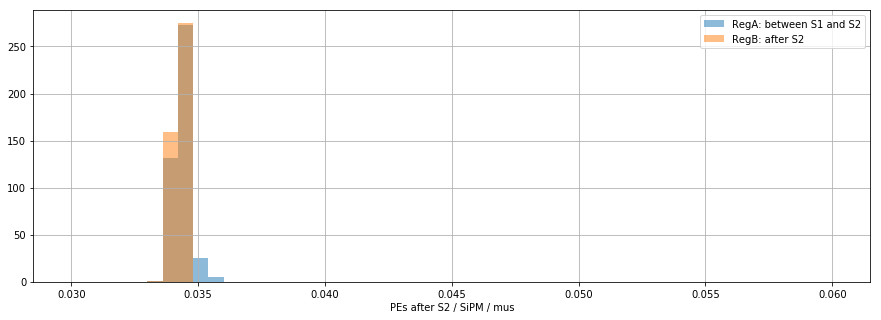

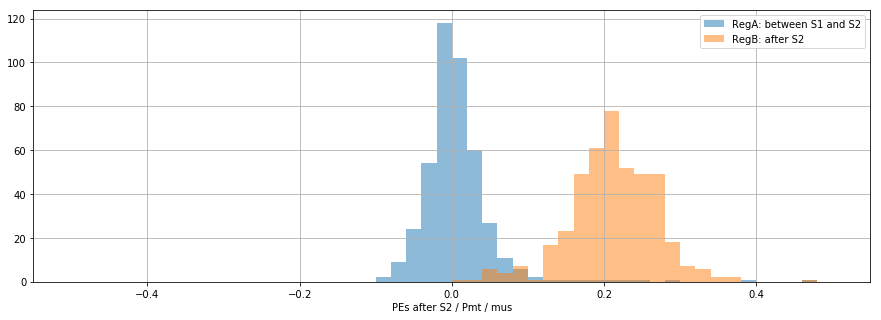

In [15]:
plt.figure(figsize=(15,5))
nza = np.nonzero(At)[0]
r=(0.03,.06)
plt.hist(Apes.mean(axis=1)[nza] / At[nza], bins = 50, alpha=.5, range=r, label='RegA: between S1 and S2')
plt.hist(Bpes.mean(axis=1)      / Bt     , bins = 50, alpha=.5, range=r, label='RegB: after S2')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
r=(-.5,.5)
plt.hist(Apes_pmt.mean(axis=1)[nza] / At[nza], bins = 50, alpha=.5, range=r, label='RegA: between S1 and S2')
plt.hist(Bpes_pmt.mean(axis=1)      / Bt     , bins = 50, alpha=.5, range=r, label='RegB: after S2')
plt.xlabel('PEs after S2 / Pmt / mus')
plt.legend()
plt.grid(True)
plt.show()

Cumulative Waveform

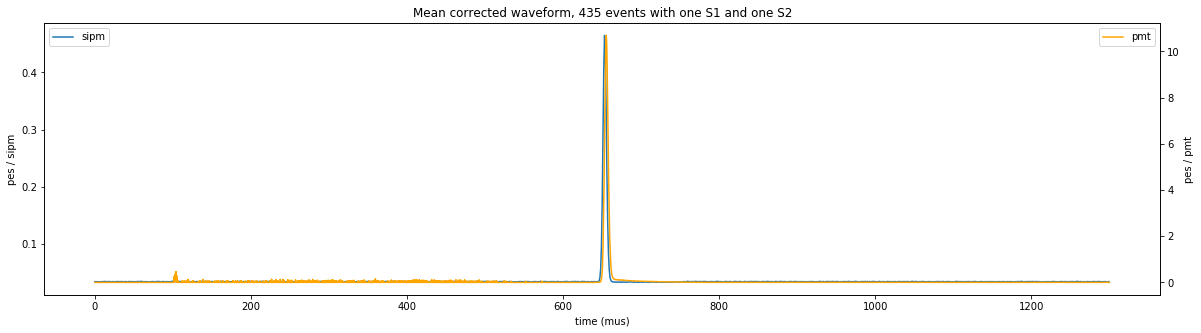

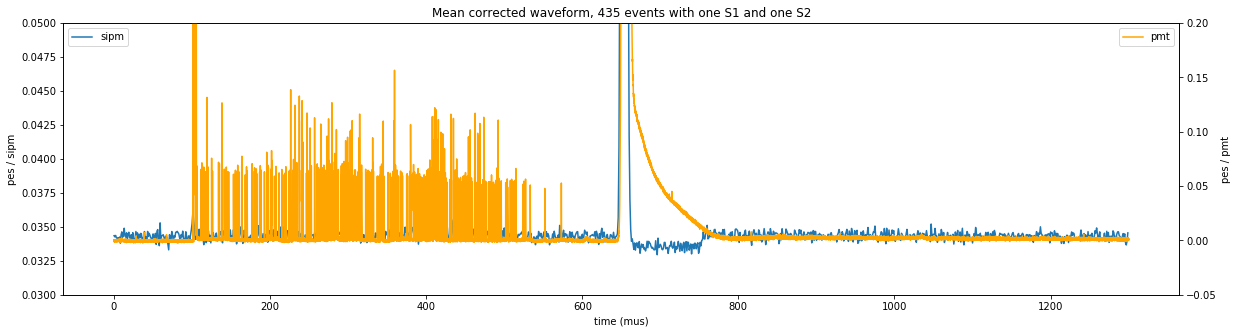

In [16]:
fig, ax1 = plt.subplots(figsize=(20,5))

sipm_ms = sipm_sum.mean(axis=0) / float(pevts)
pmt_ms  = pmt_sum .mean(axis=0) / float(pevts)

ax1.plot(range(len(sipm_ms)), sipm_ms, label='sipm')
ax1.set_xlabel('time (mus)')
ax1.set_ylabel('pes / sipm')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(np.array(range(len(pmt_ms))) / 1.0e3*25, pmt_ms, c='orange', label='pmt' )
ax2.set_ylabel('pes / pmt')
plt.title('Mean corrected waveform, ' + str(len(At)) + ' events with one S1 and one S2')
ax2.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(range(len(sipm_ms)), sipm_ms, label='sipm')
ax1.set_xlabel('time (mus)')
ax1.set_ylabel('pes / sipm')
ax1.set_ylim(0.03,.05)
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(np.array(range(len(pmt_ms))) / 1.0e3*25, pmt_ms, c='orange', label='pmt' )
ax2.set_ylabel('pes / pmt')
ax2.set_ylim(-.05,.2)
plt.title('Mean corrected waveform, ' + str(len(At)) + ' events with one S1 and one S2')
ax2.legend()
plt.show()

#### Cumulative waveform after S2

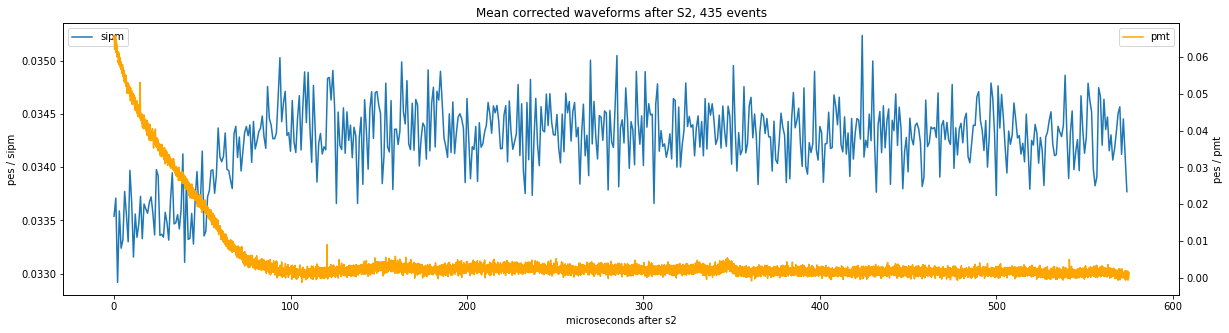

In [17]:
fig, ax1 = plt.subplots(figsize=(20,5))
start = 0
stop  = -125
Bmeansum = Bswf    .mean(axis=0)[start                   :stop                     ] / float(pevts)
Bms_pmt  = Bswf_pmt.mean(axis=0)[int(start * 1000 / 25.0): int(stop * 1000 / 25.0) ] / float(pevts)

ax1.plot(range(len(Bmeansum[np.nonzero(Bmeansum)])), 
         Bmeansum[np.nonzero(Bmeansum)], 
         label='sipm')

ax1.set_xlabel('microseconds after s2')
ax1.set_ylabel('pes / sipm')
ax1.legend(loc=2)
ax2 = ax1.twinx()

ax2.plot(np.array(range(len(Bms_pmt [np.nonzero(Bms_pmt) ]))) / 1.0e3*25, 
         Bms_pmt [np.nonzero(Bms_pmt )], 
         c='orange', label='pmt' )

ax2.set_ylabel('pes / pmt')
plt.title('Mean corrected waveforms after S2, ' + str(len(At)) + ' events')
ax2.legend()
plt.show()

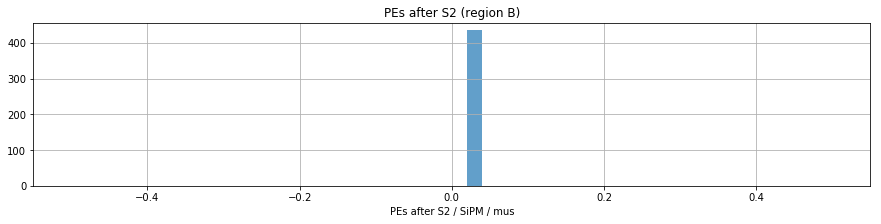

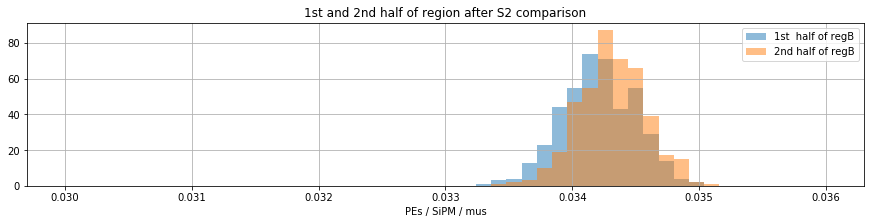

In [18]:
plt.figure(figsize=(15,3))
plt.hist(Bpes.mean(axis=1) / Bt, bins = 50, range=r, alpha=.7)
plt.title('PEs after S2 (region B)')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.grid(True)
plt.show()

binmin = min((Bspes / Bt * 2 / 1792).min(), (Bfpes / Bt * 2 / 1792).min())
binmax = max((Bspes / Bt * 2 / 1792).max(), (Bfpes / Bt * 2 / 1792).max())
normed=False
plt.figure(figsize=(15,3))
#r = binmin, binmax
r = .03, .036
plt.hist(Bspes / Bt * 2 / 1792, bins=50, normed=normed, range=r, alpha=.5, label='1st  half of regB')
plt.hist(Bfpes / Bt * 2 / 1792, bins=50, normed=normed, range=r, alpha=.5, label='2nd half of regB')
plt.grid(True)
plt.title('1st and 2nd half of region after S2 comparison')
plt.xlabel('PEs / SiPM / mus')
plt.legend()
plt.show()

Here external means sipms at R > 170.0


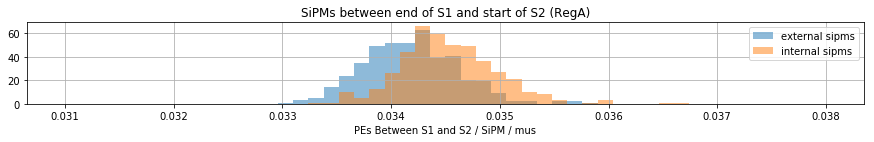

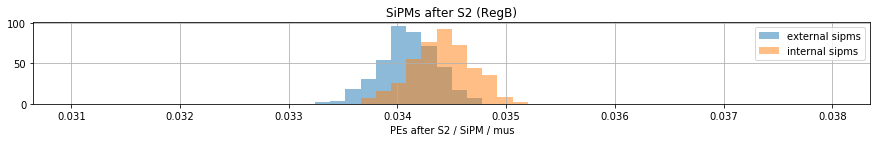

In [19]:
print('Here external means sipms at R >', ext_t)
binmin = min((Aint_pes[nza] / At[nza]).min(), (Aext_pes[nza] / At[nza]).min())
binmax = max((Aint_pes[nza] / At[nza]).max(), (Aext_pes[nza] / At[nza]).max())
binmin, binmax = (0.031, 0.038)
normed=False
plt.figure(figsize=(15,1.5))
plt.hist(Aext_pes[nza] / At[nza], bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='external sipms')
plt.hist(Aint_pes[nza] / At[nza], bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.title('SiPMs between end of S1 and start of S2 (RegA)')
plt.xlabel('PEs Between S1 and S2 / SiPM / mus')
plt.legend()
plt.show()

#binmin = min((Bext_pes / Bt).min(), (Bint_pes / Bt).min())
#binmax = max((Bext_pes / Bt).max(), (Bint_pes / Bt).max())
normed=False
plt.figure(figsize=(15,1.5))
plt.hist(Bext_pes / Bt, bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='external sipms')
plt.hist(Bint_pes / Bt, bins=50, normed=normed, range=(binmin, binmax), alpha=.5, label='internal sipms')
plt.grid(True)
plt.title('SiPMs after S2 (RegB)')
plt.xlabel('PEs after S2 / SiPM / mus')
plt.legend()
plt.show()